# New ML Run 2/27/23

In [1]:
import numpy as np
import pandas as pd
import util
import matplotlib.pyplot as plt

from sqlalchemy import create_engine, Column, Table, MetaData, insert
from sqlalchemy.types import BIGINT, FLOAT, REAL, VARCHAR, BOOLEAN

data_dir = "/global/cscratch1/sd/eramey16/data/dr9_training/unlensed_02_23/"
seed = 42

conn_string = 'postgresql+psycopg2://lensed_db_admin@nerscdb03.nersc.gov/lensed_db'

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


##### Downloaded galaxies from 6 degrees around RA 160 DEC 2
[DESI Legacy Survey](https://datalab.noirlab.edu/query.php?name=ls_dr9.photo_z)
query:
```
SELECT trac.ls_id, trac.ra, trac.dec, trac.type, trac.dered_mag_g, trac.dered_mag_r, trac.dered_mag_z, trac.dered_mag_w1, trac.dered_mag_w2,
trac.dered_flux_g, trac.dered_flux_r, trac.dered_flux_z, trac.dered_flux_w1, trac.dered_flux_w2,
trac.snr_g, trac.snr_r, trac.snr_z, trac.snr_w1, trac.snr_w2,
trac.flux_ivar_g, trac.flux_ivar_r, trac.flux_ivar_z, trac.flux_ivar_w1, trac.flux_ivar_w2,
trac.dchisq_1, trac.dchisq_2, trac.dchisq_3, trac.dchisq_4, trac.dchisq_5,
trac.rchisq_g, trac.rchisq_r, trac.rchisq_z, trac.rchisq_w1, trac.rchisq_w2,
trac.sersic, trac.sersic_ivar,
trac.psfsize_g, trac.psfsize_r, trac.psfsize_z,
trac.shape_r, trac.shape_e1, trac.shape_e2,
trac.shape_r_ivar, trac.shape_e1_ivar, trac.shape_e2_ivar,
phot_z.z_phot_median, phot_z.z_phot_std, phot_z.z_spec
FROM ls_dr9.tractor AS trac
INNER JOIN ls_dr9.photo_z AS phot_z ON trac.ls_id = phot_z.ls_id
WHERE (q3c_radial_query(ra,dec, 160, 2, 6))
AND NOT trac.type='PSF'
AND NOT trac.type='DUP'
ORDER BY trac.random_id
```

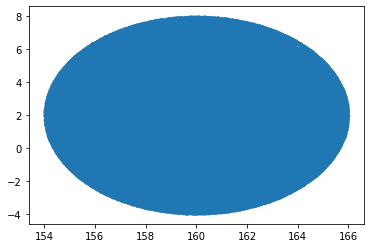

In [2]:
all_galaxies = pd.read_csv(data_dir+"dr9_160_2_6deg.dat")
plt.plot(all_galaxies.ra, all_galaxies.dec, '.', ms=1)

In [3]:
db_cols = all_galaxies.columns
clean_galaxies = util.clean_and_calc(all_galaxies, mode='dr9')
clean_galaxies = clean_galaxies.sample(n=10000, random_state=seed).reset_index(drop=True)
clean_galaxies = clean_galaxies[db_cols]

/global/homes/e/eramey16/.conda/envs/myprospector/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
engine = create_engine(conn_string)
conn = engine.connect()

util.bookkeeping_setup(conn, 'cosmos_160', clean_galaxies, tag='run2')

In [5]:
pd.DataFrame(conn.execute("SELECT * from bookkeeping"))

,id,tbl_id,tbl_name,ls_id,created,stage,tag
0,1,1,cosmos_160,9906621743042266,2023-03-07 22:20:19.058976,1,run2
1,2,2,cosmos_160,9906621271050433,2023-03-07 22:20:19.077879,1,run2
2,3,3,cosmos_160,9906621648077981,2023-03-07 22:20:19.083887,1,run2
3,4,4,cosmos_160,9906621929816416,2023-03-07 22:20:19.091293,1,run2
4,5,5,cosmos_160,9906621647291909,2023-03-07 22:20:19.096316,1,run2
...,...,...,...,...,...,...,...
9995,9996,9996,cosmos_160,9906622309140574,2023-03-07 22:21:44.205694,1,run2
9996,9997,9997,cosmos_160,9906621460125395,2023-03-07 22:21:44.211451,1,run2
9997,9998,9998,cosmos_160,9906623439438358,2023-03-07 22:21:44.219393,1,run2
9998,9999,9999,cosmos_160,9906622213654027,2023-03-07 22:21:44.225291,1,run2


In [6]:
conn.execute("SELECT * from cosmos_160").first()

(9906621743042266, 162.910029571106, 0.81542817820044, 'REX', 23.42378, 22.469233, 21.555038, 20.804296, 21.673061, 0.427059, 1.028744, 2.387727, 4.767399, 2.141782, 14.504388, 22.860104, 25.552435, 8.278383, 1.702473, 1527.4186, 596.59454, 127.30318, 3.064141, 0.638112, 1297.0767, 1389.1155, 1384.5988, 1395.198, 0.0, 0.982051, 0.876592, 1.034885, 0.561166, 0.506167, 1.0, 0.0, 1.39972, 1.306459, 1.392947, 0.364783, 0.0, 0.0, 1755.2955, 0.0, 0.0, 0.698765, 0.079279, -99.0, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 1)

In [7]:
conn.close()

### Running classify

In [1]:
from docker import classify
import util
import sqlalchemy
import pandas as pd
import numpy as np

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
bkdata, tbldata = classify.get_galaxy(ls_id=9906621743042266)
gal_data = tbldata.iloc[0]

In [3]:
# tbldata

In [4]:
gal_data.z_phot_median

0.698765

In [5]:
bands = ['g', 'r', 'z', 'w1', 'w2']

print([gal_data[f'dered_mag_{b}'] for b in bands])

[23.42378, 22.469233, 21.555038, 20.804296, 21.673061]


In [6]:
print([ 2.5 / (np.log(10) * gal_data['dered_flux_'+b] * 
                        np.sqrt(gal_data['flux_ivar_'+b])) for b in bands])

[0.06505151325479806, 0.04320931361045458, 0.04030138982839337, 0.1301033400196666, 0.6346007773114765]


In [7]:
h5_file = "/global/cscratch1/sd/eramey16/data/dr9_training/unlensed_02_23/9906621743042266.h5"
gal_data = classify.merge_prospector(tbldata, h5_file=h5_file)

Object found: 9906621743042266
Redshift: 0.698765


In [8]:
mfile = "/global/homes/e/eramey16/galactic_lenses/gridsearch_models/gridsearch_2023-02-15.sav"
pred = classify.predict(gal_data, model_file=mfile)
gal_data['lensed'] = pred

In [9]:
# classify.update_db(bkdata, gal_data)

first done


In [3]:
engine = sqlalchemy.create_engine(util.conn_string)
conn = engine.connect()

In [4]:
conn.execute("SELECT * from cosmos_160 where ls_id=9906621743042266").first()

(9906621743042266, 162.910029571106, 0.81542817820044, 'REX', 23.42378, 22.469233, 21.555038, 20.804296, 21.673061, 0.427059, 1.028744, 2.387727, 4.767399, 2.141782, 14.504388, 22.860104, 25.552435, 8.278383, 1.702473, 1527.4186, 596.59454, 127.30318, 3.064141, 0.638112, 1297.0767, 1389.1155, 1384.5988, 1395.198, 0.0, 0.982051, 0.876592, 1.034885, 0.561166, 0.506167, 1.0, 0.0, 1.39972, 1.306459, 1.392947, 0.364783, 0.0, 0.0, 1755.2955, 0.0, 0.0, 0.698765, 0.079279, -99.0, 4.27059119198179e-10, 1.02874277944854e-09, 2.38772771266793e-09, 4.76740008625971e-09, 2.14178365534728e-09, 2.63691629192768e-11, 4.17667199258915e-11, 9.02954181568338e-11, 6.06912664544251e-10, 1.70073434754316e-09, 4.56131768358815e-10, 9.68571501943363e-10, 2.43840683243489e-09, 4.5565034617454e-09, 2.97225793854728e-09, 0.570826260065676, 0.222393715374206, 10.1173792169235, -0.0237380588507266, -0.936602424868841, 0.185024294190844, 0.096018752583561, 0.0660736808940854, 0.206412383037788, 0.166462641587396, 0

In [6]:
conn.execute("SELECT * from bookkeeping where id=1").first()

(1, 1, 'cosmos_160', 9906621743042266, datetime.datetime(2023, 3, 7, 0, 13, 7, 456273), 2, 'run2')